In [2]:
import dgl
import dgl.function as fn
import torch as th
import torch.nn as nn
import torch.nn.functional as F
from dgl import DGLGraph
import pandas as pd
import torch
import sklearn.metrics
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init

In [3]:
df = pd.read_csv("pokec-df-processed2.csv", index_col=0)

In [4]:
edges = pd.read_csv("pokec-edges-processed2.csv", index_col=0)

In [5]:
# фичи и возраст
node_features = df.loc[:, df.columns != 'AGE'].values
node_labels = df.loc[:, df.columns == 'AGE'].values.flatten()
node_features = torch.FloatTensor(node_features)
node_labels = torch.LongTensor(node_labels)

In [6]:
num_features = node_features.shape[1]
num_classes = (node_labels.max() + 1).item()

In [7]:
graph = dgl.graph((edges.values[:, 0], edges.values[:, 1]))

In [8]:
ind = df.index.values
with open('train2.txt', 'r') as file:
    train_nids = [int(x) for x in file]
with open('test2.txt', 'r') as file:
    test_nids = [int(x) for x in file]

In [9]:
from dgl.nn import GraphConv

class NGNN_GCNConv(torch.nn.Module):
    def __init__(self, input_channels, hidden_channels, output_channels):
        super(NGNN_GCNConv, self).__init__()
        self.conv = GraphConv(input_channels, hidden_channels)
        self.fc = nn.Linear(hidden_channels, output_channels)

    def forward(self, g, x, edge_weight=None):
        x = self.conv(g, x, edge_weight)
        x = F.relu(x)
        x = self.fc(x)
        return x

In [10]:
class NGNN_GCN(nn.Module):
    def __init__(self, input_channels, hidden_channels, output_channels):
        super(NGNN_GCN, self).__init__()
        self.conv1 = NGNN_GCNConv(input_channels, hidden_channels, hidden_channels)
        self.conv2 = GraphConv(hidden_channels, output_channels)
        self.dropout = nn.Dropout(p=0.5)

    def forward(self, g, input_channels):
        h = self.conv1(g, input_channels)
        h = F.relu(h)
        h = self.dropout(h)
        h = self.conv2(g, h)
        return h

In [11]:
def predict(g, features, labels, mask, model):
    model.eval()
    with torch.no_grad():
        logits = model(g, features)
        logits = logits[mask]
        labels = labels[mask]
        _, indices = torch.max(logits, dim=1)
        return indices

In [13]:
best_model_path = 'NGNN_model.pt'

Epoch 00000 | Loss 10.0369 | mae 48.8254 | Time(s) 2.8040
Epoch 00001 | Loss 8.3020 | mae 47.6258 | Time(s) 2.3045
Epoch 00002 | Loss 7.0572 | mae 44.3575 | Time(s) 2.5688
Epoch 00003 | Loss 6.1926 | mae 40.9284 | Time(s) 2.3872
Epoch 00004 | Loss 5.5950 | mae 36.9534 | Time(s) 2.3536
Epoch 00005 | Loss 5.1695 | mae 32.0145 | Time(s) 2.3112
Epoch 00006 | Loss 4.8687 | mae 25.7758 | Time(s) 2.4619
Epoch 00007 | Loss 4.6507 | mae 7.9018 | Time(s) 2.2220
Epoch 00008 | Loss 4.4886 | mae 7.4268 | Time(s) 2.2861
Epoch 00009 | Loss 4.3753 | mae 7.3476 | Time(s) 2.7439
Epoch 00010 | Loss 4.2850 | mae 7.2480 | Time(s) 2.3420
Epoch 00011 | Loss 4.2112 | mae 7.1152 | Time(s) 2.3666
Epoch 00012 | Loss 4.1435 | mae 7.0480 | Time(s) 2.2680
Epoch 00013 | Loss 4.0803 | mae 6.9616 | Time(s) 2.3277
Epoch 00014 | Loss 4.0194 | mae 6.9247 | Time(s) 2.4540
Epoch 00015 | Loss 3.9681 | mae 6.9247 | Time(s) 2.2907
Epoch 00016 | Loss 3.9267 | mae 6.9388 | Time(s) 2.3758
Epoch 00017 | Loss 3.8831 | mae 6.9680 |

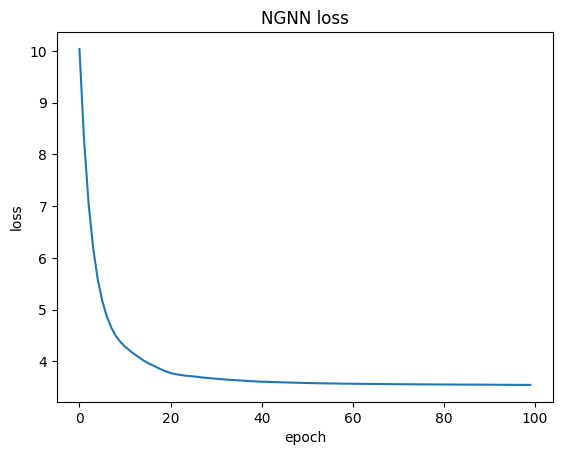

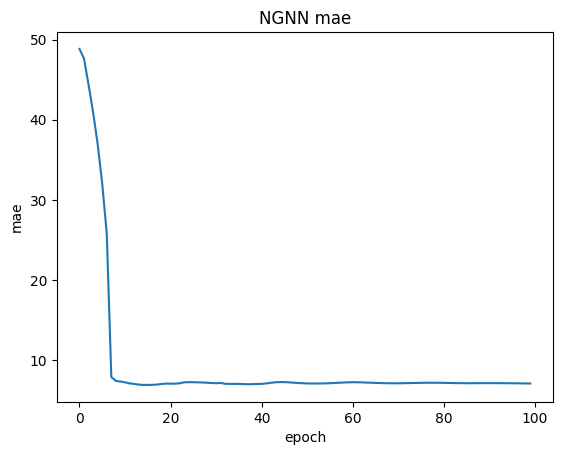

In [14]:
import time

import numpy as np
model = NGNN_GCN(num_features, 9, num_classes)
g = graph
features = node_features
labels = node_labels
train_mask = torch.BoolTensor(np.isin(ind, train_nids))
test_mask = torch.BoolTensor(np.isin(ind, test_nids))
best_mae = 10**10
# Add edges between each node and itself to preserve old node representations
g.add_edges(g.nodes(), g.nodes())
optimizer = th.optim.Adam(model.parameters(), lr=1e-2)
train_loss = []
train_mae = []
num_epochs = 100
for epoch in range(num_epochs):
    t0 = time.time()
    model.train()
    logits = model(g, features)
    logp = F.log_softmax(logits, 1)
    loss = F.nll_loss(logp[train_mask], labels[train_mask])
    train_loss.append(loss.item())
    train_mae.append(sklearn.metrics.mean_absolute_error(predict(g, features, labels, train_mask, model).numpy(), labels[train_mask].numpy()))
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    print(
        "Epoch {:05d} | Loss {:.4f} | mae {:.4f} | Time(s) {:.4f}".format(
            epoch, loss.item(), train_mae[-1], time.time() - t0
        )
    )
    if best_mae > train_mae[-1]:
        best_mae = train_mae[-1]
        torch.save(model.state_dict(), best_model_path)
# plot loss
plt.plot(train_loss)
plt.title('NGNN loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()
# plot accuracy
plt.plot(train_mae)
plt.title('NGNN mae')
plt.ylabel('mae')
plt.xlabel('epoch')
plt.show()

In [17]:
model.load_state_dict(torch.load(best_model_path))

<All keys matched successfully>

In [18]:
test_predictions = predict(g, features, labels, test_mask, model)
test_labels = node_labels[test_nids]
test_mae = sklearn.metrics.mean_absolute_error(test_predictions.numpy(), test_labels.numpy())
print('Test MAE:', test_mae)

Test MAE: 6.930888873249349
